In [183]:
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from functools import reduce
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier,RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, plot_roc_curve,plot_confusion_matrix, accuracy_score, precision_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder

# 1. Data exploration - load and merge feature and label data of the train set

## load and split data to training and test sets

In [184]:
#load feature_data
X = pd.read_csv("feature_data.csv")
#load_label_data
y = pd.read_csv("label_data.csv")
#change_column_names
X = X.rename(columns = {'Unnamed: 0':'id'})
y = y.rename(columns = {'Unnamed: 0':'id'})
X.head()

#split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25,random_state = 42,shuffle = True)

#merge X,y for later
new_df=pd.merge(X_train,y_train,on=['id'])
new_df.head()

,id,time_until_order,order_year,order_month,order_week,order_day_of_month,adults,children,babies,country,...,anon_feat_5,anon_feat_6,anon_feat_7,anon_feat_8,anon_feat_9,anon_feat_10,anon_feat_11,anon_feat_12,anon_feat_13,cancelation
0,32696,5.0,2017,January,week_5,30,2,2.0,0,MAR,...,6.0,0.0,1.0,0,1.0,0.502086,2.050217,True,0.0,False
1,27250,127.0,2017,August,week_33,18,2,0.0,0,PRT,...,4.0,0.0,NaN,4,1.0,0.444252,11.344172,False,NaN,False
2,84393,22.0,2016,February,week_9,22,2,0.0,0,PRT,...,3.0,0.0,0.0,1,NaN,0.551103,4.793369,False,NaN,False
3,109652,NaN,2017,April,week_15,9,2,0.0,0,GBR,...,0.0,0.0,0.0,1,0.0,0.319022,10.610277,False,NaN,False
4,116988,NaN,2017,July,week_30,25,3,0.0,0,FRA,...,3.0,0.0,1.0,0,0.0,0.492604,14.314214,True,0.0,False


In [185]:
#basic data info
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89542 entries, 0 to 89541
Data columns (total 34 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   89542 non-null  int64  
 1   time_until_order     76861 non-null  float64
 2   order_year           89542 non-null  int64  
 3   order_month          86108 non-null  object 
 4   order_week           89542 non-null  object 
 5   order_day_of_month   89542 non-null  int64  
 6   adults               89542 non-null  int64  
 7   children             89538 non-null  float64
 8   babies               89542 non-null  int64  
 9   country              85201 non-null  object 
 10  order_type           89542 non-null  object 
 11  acquisition_channel  89542 non-null  object 
 12  prev_canceled        89542 non-null  int64  
 13  prev_not_canceled    89542 non-null  int64  
 14  changes              86065 non-null  float64
 15  deposit_type         80536 non-null 

In [186]:
X.describe()

,id,time_until_order,order_year,order_day_of_month,adults,children,babies,prev_canceled,prev_not_canceled,changes,...,anon_feat_3,anon_feat_4,anon_feat_5,anon_feat_6,anon_feat_7,anon_feat_8,anon_feat_9,anon_feat_10,anon_feat_11,anon_feat_13
count,89542.000000,76861.000000,89542.000000,89542.000000,89542.000000,89538.000000,89542.000000,89542.000000,89542.000000,86065.000000,...,89542.000000,89542.000000,85510.000000,85309.000000,85294.000000,89542.000000,85811.000000,86810.000000,84585.000000,5776.000000
mean,59716.762871,103.673879,2016.157658,15.828807,1.857497,0.103732,0.007896,0.087411,0.137701,0.223877,...,0.032231,0.989971,1.330944,2.339401,0.062607,0.571922,0.335691,0.427146,8.845679,0.365132
std,34495.242240,106.940156,0.707461,8.779753,0.565296,0.397797,0.095194,0.849799,1.496269,0.663361,...,0.176613,1.698086,1.879927,17.516854,0.243415,0.793567,0.472234,0.128140,5.236673,0.481509
min,0.000000,0.000000,2015.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.161008,0.038632,0.000000
25%,29838.250000,18.000000,2016.000000,8.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.328012,4.452191,0.000000
50%,59743.500000,69.000000,2016.000000,16.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.425622,8.422255,0.000000
75%,89610.500000,159.000000,2017.000000,23.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,3.000000,3.000000,0.000000,0.000000,1.000000,1.000000,0.511077,12.712815,1.000000
max,119388.000000,737.000000,2017.000000,31.000000,55.000000,10.000000,10.000000,26.000000,72.000000,21.000000,...,1.000000,9.000000,11.000000,391.000000,3.000000,5.000000,1.000000,0.907525,27.172399,1.000000


In [187]:
#empty_val_stats - 
def na_stats (df):
    df.isnull().sum()
    total = df.isnull().sum()
    percent_missing = df.isnull().sum() * 100 / len(df)
    missing_value_df = pd.DataFrame({'total': total,
                                     'percent_missing': percent_missing})
    missing_value_df.sort_values('percent_missing', inplace=True, ascending=False)
    return missing_value_df
print(na_stats (X))
# note: we can restore NA values of 'month' from corresponding 'week', which indicates they have strong
# corelation and we can maybe exclude one of them

                     total  percent_missing
company              84480        94.346787
anon_feat_13         83766        93.549396
time_until_order     12681        14.162069
agent                12196        13.620424
customer_type         9895        11.050680
deposit_type          9006        10.057850
anon_feat_11          4957         5.535950
country               4341         4.848004
anon_feat_7           4248         4.744142
anon_feat_6           4233         4.727390
anon_feat_5           4032         4.502915
anon_feat_9           3731         4.166760
changes               3477         3.883094
order_month           3434         3.835072
anon_feat_0           3381         3.775882
adr                   2983         3.331398
anon_feat_10          2732         3.051082
children                 4         0.004467
anon_feat_8              0         0.000000
anon_feat_3              0         0.000000
anon_feat_12             0         0.000000
anon_feat_4              0      

<AxesSubplot:>

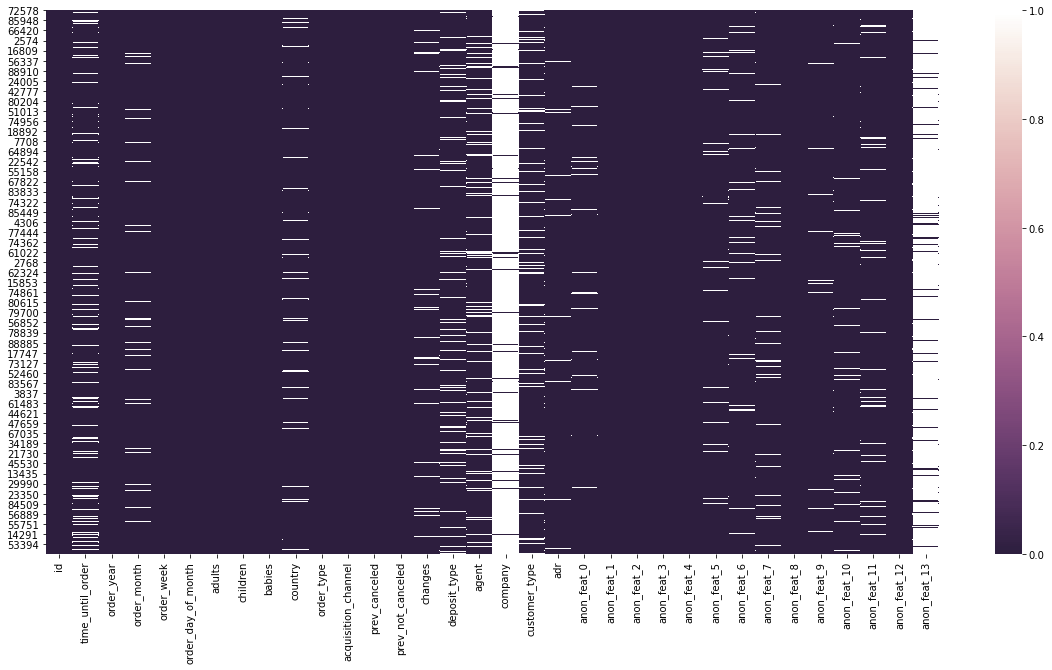

In [188]:
#plot null values per column
%matplotlib inline
plt.figure(figsize=(20, 10))
cmap = sns.cubehelix_palette(light=1, as_cmap=True, reverse=True)
sns.heatmap(X_train.isnull(), cmap=cmap)
#columns we might want to drop due to multyple NA ['company','anon_feat_13'-probably not]


In [189]:
#load test to see if NA stats are same as X stats
T = pd.read_csv("feature_data_test.csv")
T = T.rename(columns = {'Unnamed: 0':'id'})
print(na_stats (T))

#looks pretty similar, that means that we can trust that the precudures we'll be doing on the training/test set, will influance
#the final test set in a similar way.

                     total  percent_missing
company              28113        94.187215
anon_feat_13         27905        93.490351
time_until_order      4253        14.248861
agent                 4144        13.883677
customer_type         3287        11.012463
deposit_type          3051        10.221790
anon_feat_11          1689         5.658671
anon_feat_6           1410         4.723935
country               1407         4.713884
anon_feat_7           1368         4.583222
anon_feat_5           1352         4.529617
anon_feat_9           1254         4.201287
order_month           1167         3.909810
changes               1104         3.698740
anon_feat_0           1091         3.655186
adr                   1027         3.440767
anon_feat_10           896         3.001876
anon_feat_8              0         0.000000
anon_feat_2              0         0.000000
anon_feat_4              0         0.000000
anon_feat_12             0         0.000000
anon_feat_3              0      

# Numerical and categorial features

## Split to numerical and categorial data

In [190]:
def num_cat_split(X):
    X_num = X.select_dtypes(include=[np.number])
    X_categ = X.select_dtypes(exclude=[np.number])
    return X_num, X_categ

X_num, X_categ = num_cat_split(X_train)

## Functions for handeling 'country' feature 

#### Our idea for handeling this feature is to unite all the tail into a new 'other' county,  thus still maintain most of the data variety, but also maintain low dimention

In [191]:
# find the threshold for number of countries before handeling the data
def get_country_index (X):
    threshold = [0.90,0.95,0.99]
    print("Threshold:",threshold)
    print("Number of countries included in this threshold:\n",X['country'].value_counts(normalize=True).cumsum().searchsorted(threshold))
    country_indx = X['country'].value_counts(normalize=True).cumsum().searchsorted(threshold[0])
    print ("\nWe chose to use {} countries in order to describe 90% of the data". format(country_indx))

# seems like 90% of the data is represented by 13 countries in the training 
# and we have 155 countries that can be dealt otherwise

def change_country_outliers (X):
    countries_in_threshold = X['country'].value_counts(normalize=True)[13:].index.tolist()
    X['country'].replace(to_replace=countries_in_threshold, value="OTHER", inplace=True)
    return X
# We replace with other because there is not alot of missing data in the country
def fillna_country(X):
    X.country.fillna("OTHER",inplace=True)
    return X

def country_to_num(X):
    le = LabelEncoder()
    le.fit(X.country.unique())
    X['country'] = le.transform(X['country'])
    return (X)

def pie_chart (X):
    sizes = X['country'].value_counts().sort_index() / X['country'].value_counts().sum() * 100
    plt.pie(sizes, labels=sizes.index, autopct='%1.1f%%', shadow=True, startangle=140)
    plt.axis('equal')
    plt.legend(sizes.index, loc="best")
    plt.tight_layout()
    print ("\nCountry distribution after taking the 10% tail into a new 'other' country:")
    plt.show()


## Handeling other catecorial features

In [192]:
# we can easily deal with 'order_month','order_week' by converting them to their corresponding numbers,
# and 'anon_feat_12' to binary values. All the other categories will get mapped numbers for each value 
c = X_categ.copy()
months = {'January':1,'February':2,'March':3,'April': 4,'May': 5,'June': 6,'July': 7,'August': 8,'September': 9,'October': 10,'November': 11,'December': 12}
# we will probable want to use get_dummies for those, for now i'm changing it so we can look at correlations with lables
order_t = {'Offline TA/TO':1,'Online TA':2,'Direct':3,'Corporate':4,'Groups':5,'Aviation':6,'Complementary':7,'Undefined':8}
acq_c = {'TA/TO':1,'GDS':2,'Direct':3,'Corporate':4,'Undefined':5}
dep_t = {'No Deposit':1,'Non Refund':2,'Refundable':3}
cus_t = {'Transient-Party':1,'Transient':2,'Contract':3,'Group':4}
categories = ['order_month','order_type','acquisition_channel','deposit_type','customer_type']
categ_dicts = [months, order_t, acq_c, dep_t, cus_t]


Threshold: [0.9, 0.95, 0.99]
Number of countries included in this threshold:
 [13 21 55]

We chose to use 13 countries in order to describe 90% of the data

Country distribution after taking the 10% tail into a new 'other' country:


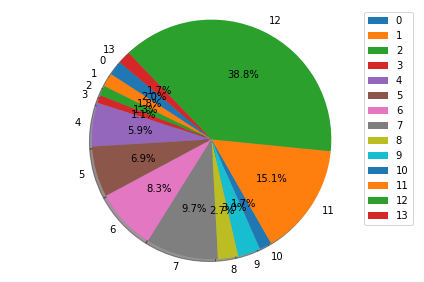

In [193]:
def replace_cat(X, categories, val_dicts):
    #'order_month','order_type','acquisition_channel','deposit_type','customer_type'
    for cat, dic in zip(categories ,val_dicts):
        X[cat].replace(dic, inplace=True)
        
    # week, and use values to fill NA for months
    X['order_week'] = X['order_week'].str.slice(start=5).apply(pd.to_numeric)
    X['order_month'].fillna((X['order_week']/4.3).apply(np.ceil), inplace = True)  #calc month for NA values from week
    
    # anon_feat_12
    X['anon_feat_12'] = X['anon_feat_12'].astype(int)
    
    #country
    get_country_index(X)
    X = change_country_outliers(X)
    X = fillna_country(X)
    X = country_to_num(X)
    #plotting the results of country preproccesing
    pie_chart (X)
    return X

c = replace_cat(c, categories, categ_dicts)
c.head()
#joining data to numerical dataframe
X_num = X_num.join(c)

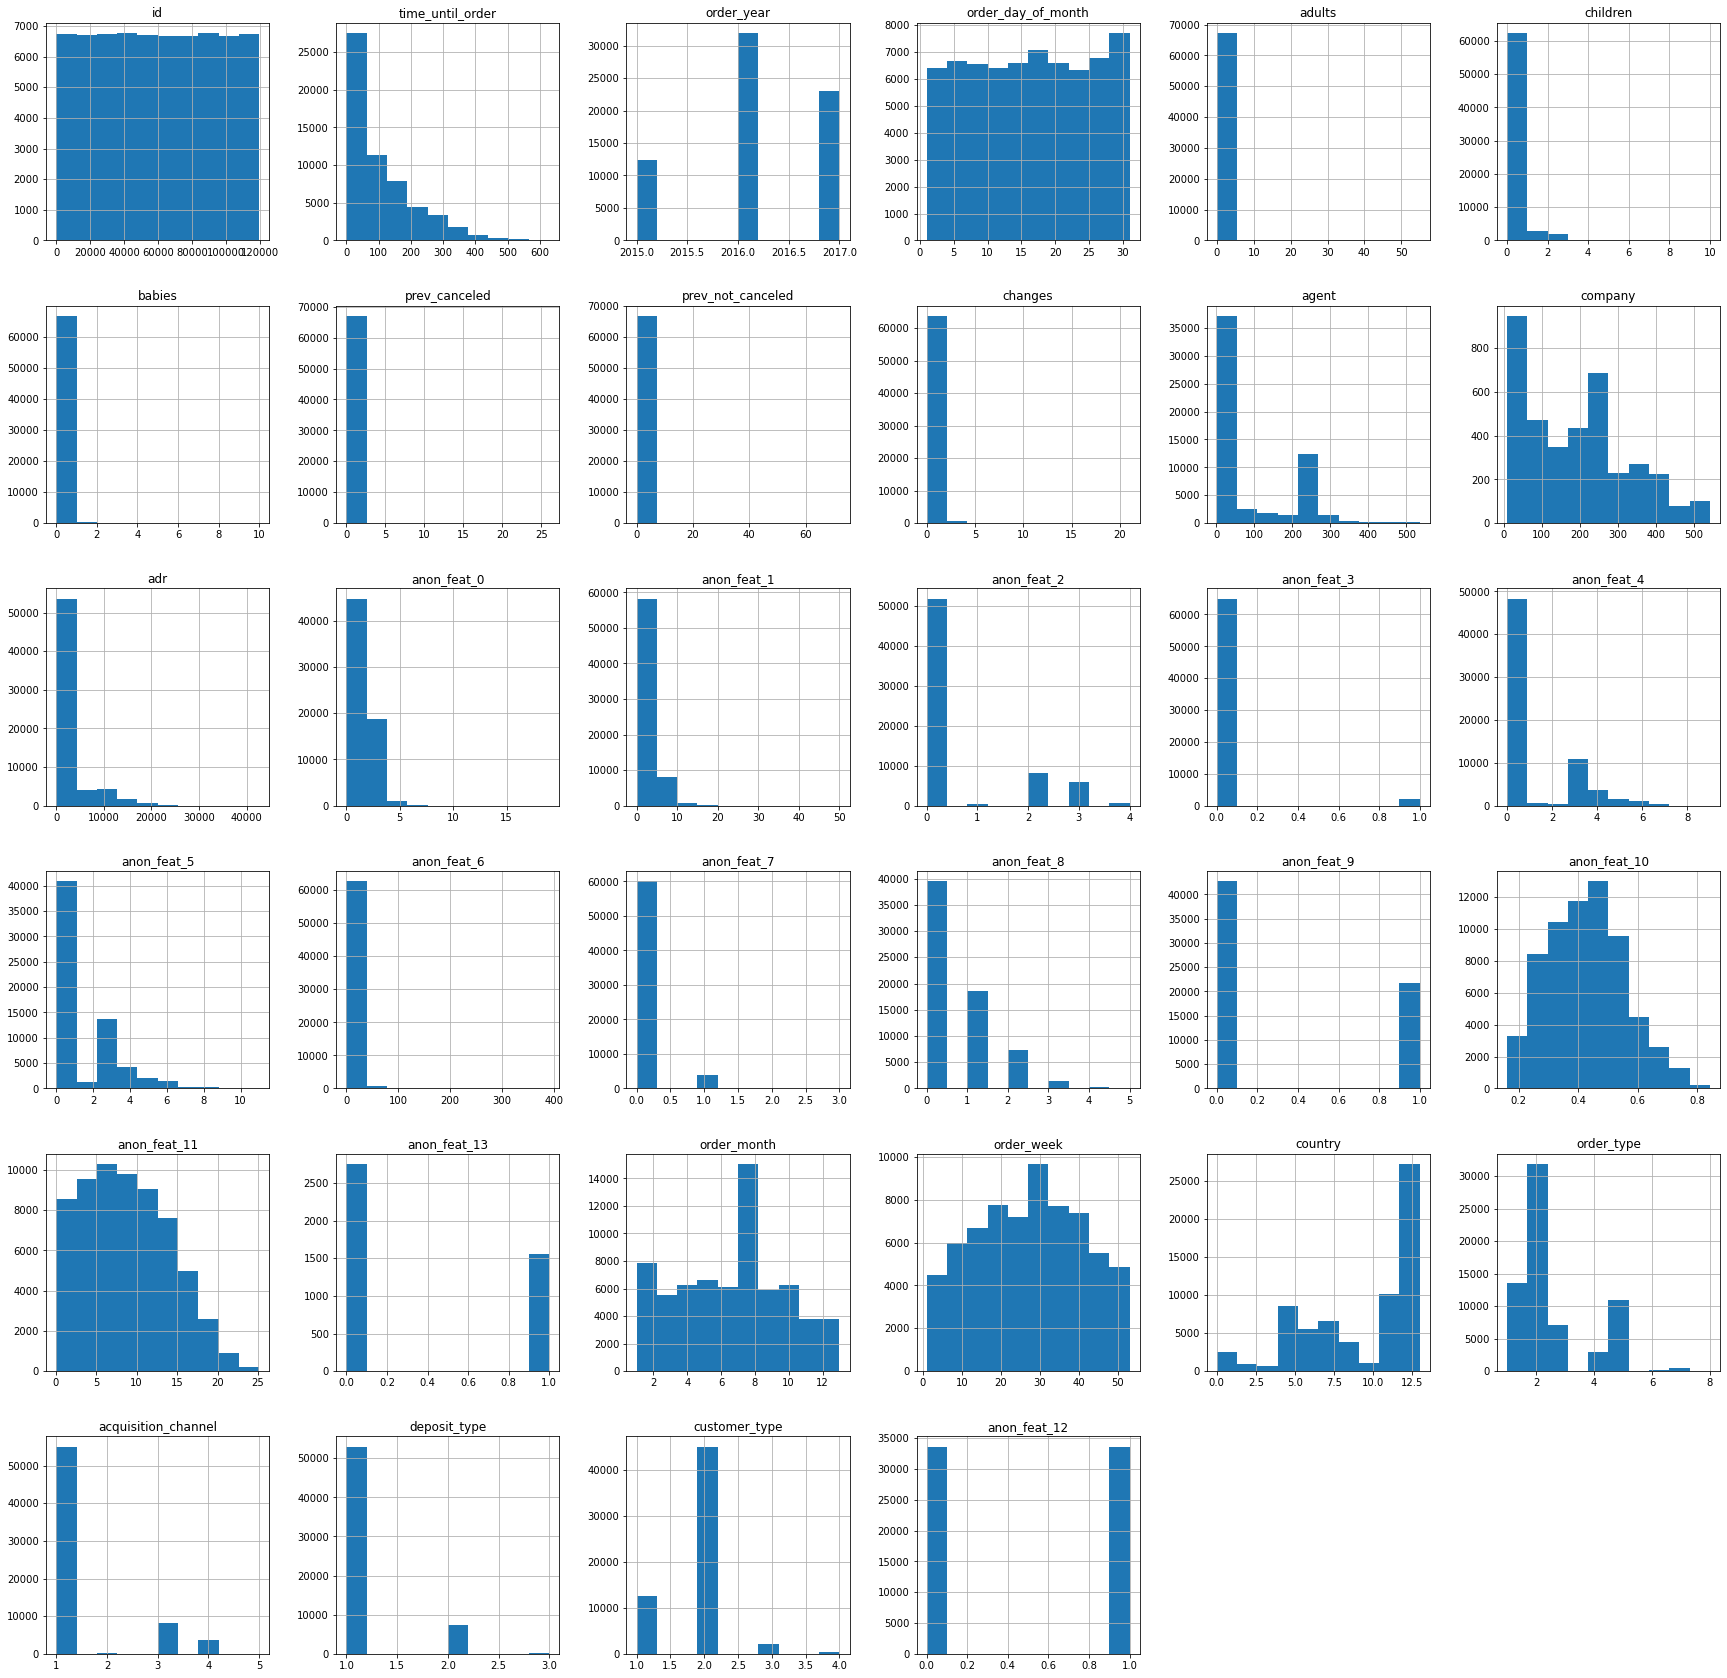

In [194]:
#Feature_histogram
X_num.hist(figsize=(30,30))
plt.show()

## Some initial conclusions:

#### * outlayers:
##### 1. we will probably want to handle ['adults','children','babies','adr','annot_feat_0-1','changes']
##### 2. we will handle these features differently, because we get an intuition that these outlayers will be important
##### ['prev_not_canceled',prev_canceled','annot_feat_6']

#### * get dummies for: ['country','order_type','acquisition_channel','deposit_type','customer_type']

#### * normalization = ['']?

#### * log = ['time_until_order']?

# Correlations between features (w/o lables)

In [195]:
#features thoughts:
#agent - maybe its also categorial?

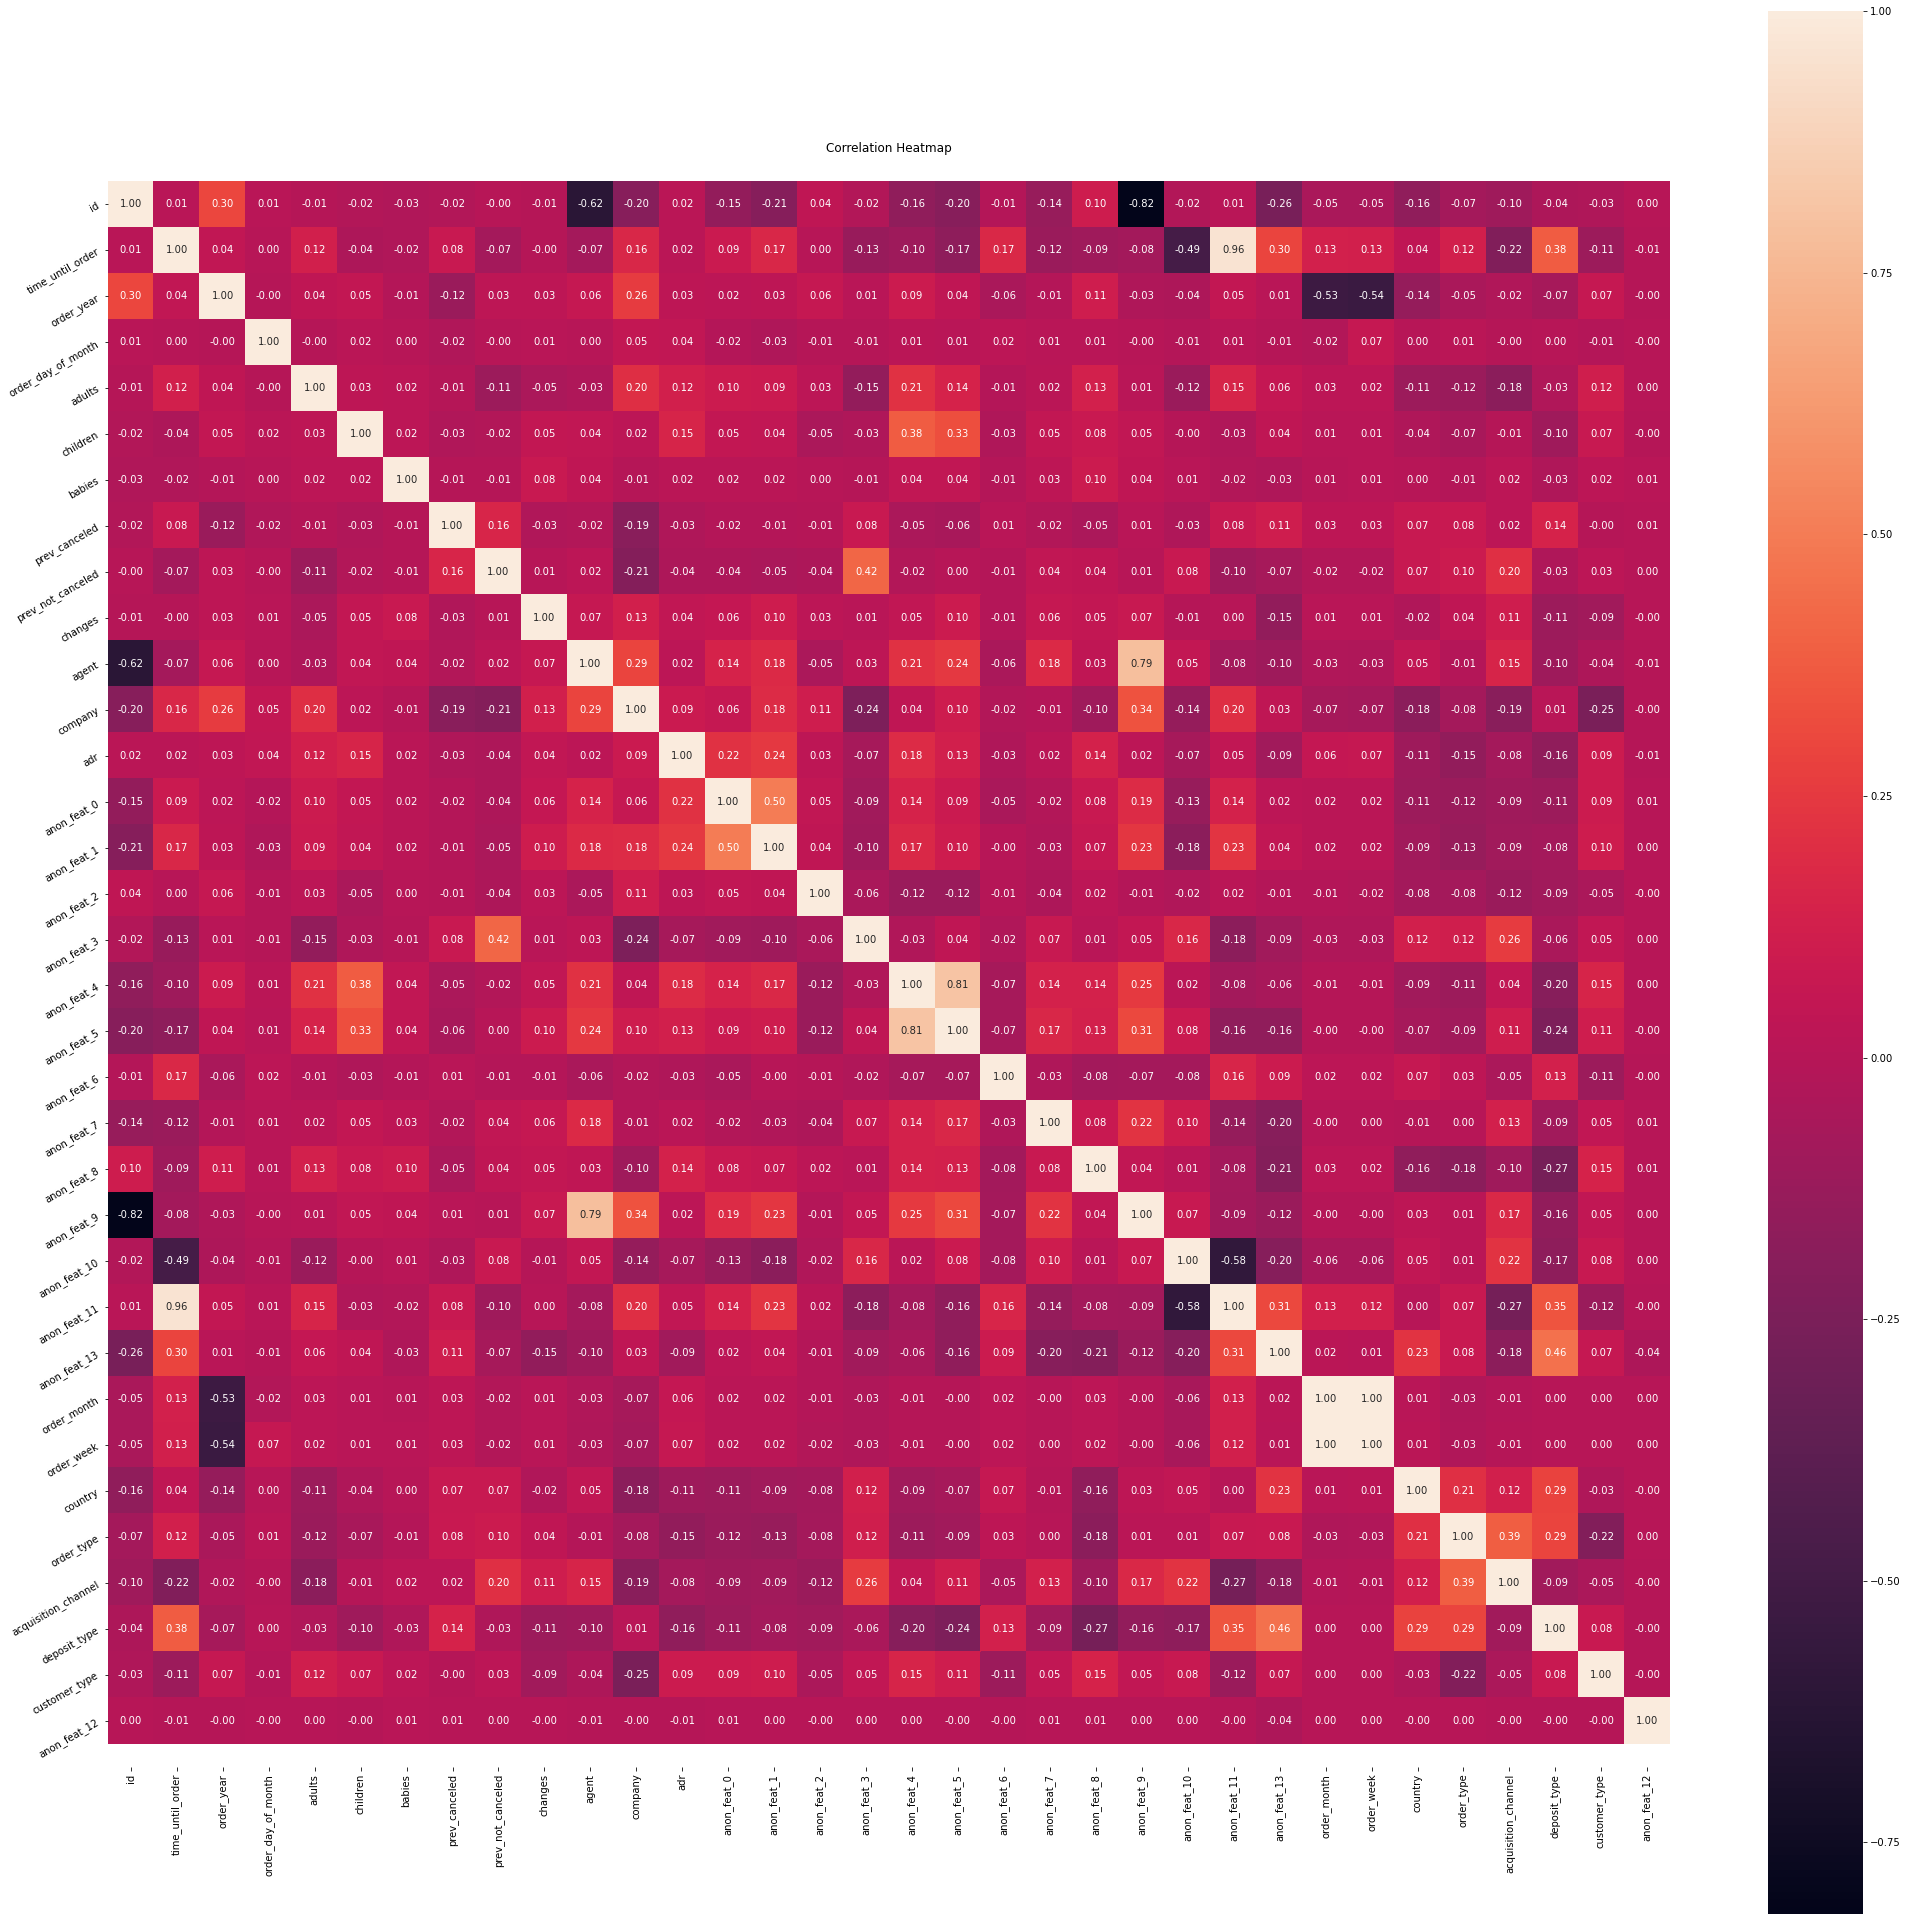

In [196]:
correlation = X_num.corr()
plt.figure(figsize=(35,35))
plt.title('Correlation Heatmap')
ax = sns.heatmap(correlation, square=True, annot=True, fmt='.2f', linecolor='white')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)                 
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_yticklabels(ax.get_yticklabels(), rotation=30)           
plt.show()

# We see high correlation between time_until_order to anon_feat_11 - maybe delete one of them, after we check correlation w labels
# We see high correlation between agent(and id) and anon_feat_9 - but 9 is binary, so it's weird. we'll leave it
# We see high correlation between anon_feat_4 and anon_feat_5 - delete 5 because he has missing values - yes.
# We see low correlation between anon_feat_10 and anon_feat_11



# Correlations with lables

In [197]:
X_num.corrwith(y['cancelation']).sort_values(ascending=False)

anon_feat_13           1.000000
deposit_type           0.465093
anon_feat_11           0.312541
time_until_order       0.292467
country                0.254068
order_type             0.111057
prev_canceled          0.108540
customer_type          0.084831
anon_feat_6            0.058195
adults                 0.056654
anon_feat_1            0.027683
order_month            0.014931
order_year             0.014521
order_week             0.012003
children               0.005075
anon_feat_0           -0.000334
anon_feat_12          -0.007302
order_day_of_month    -0.009336
anon_feat_2           -0.016290
company               -0.019220
babies                -0.032507
prev_not_canceled     -0.060029
anon_feat_4           -0.061918
adr                   -0.070128
agent                 -0.081958
anon_feat_3           -0.088319
anon_feat_9           -0.136613
changes               -0.143720
acquisition_channel   -0.166873
anon_feat_5           -0.177555
anon_feat_7           -0.197715
anon_fea

In [198]:
# features that seem to have high corellation with lable (meaning we get the intuition they're important 
#['time_until_order'?,'order_year','order_day_of_month','agent','annot_feat_2,6,12','','','','','','',]
# features that apears strong ['annot_feat_9,10','deposit_type','agent']

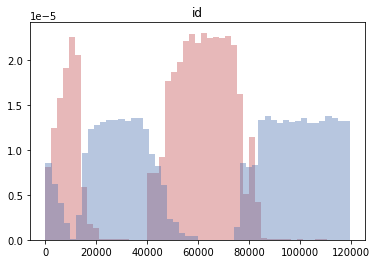

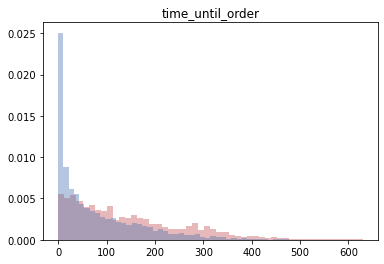

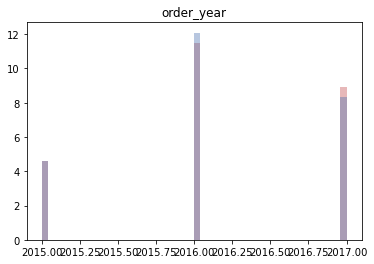

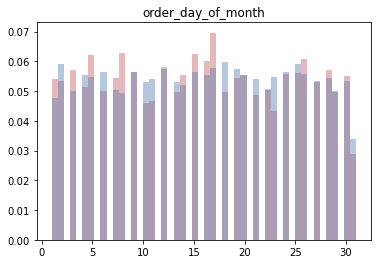

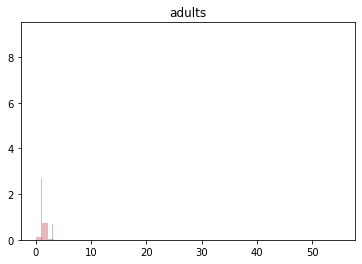

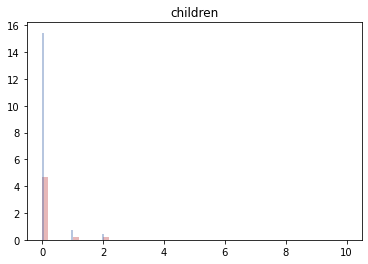

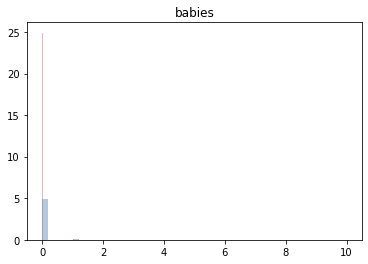

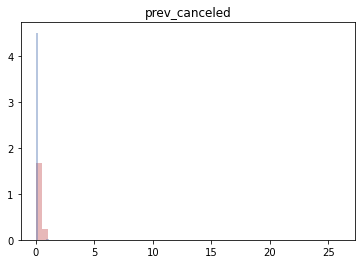

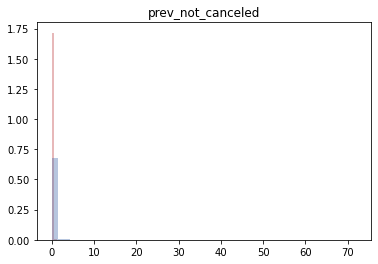

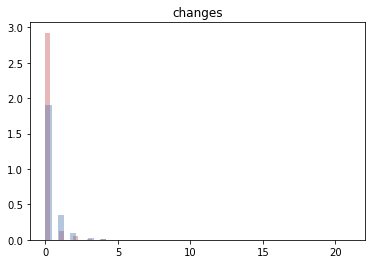

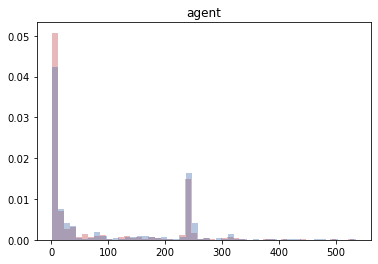

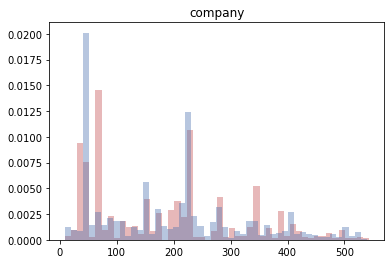

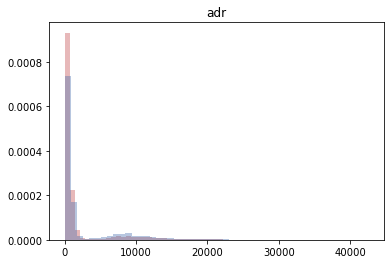

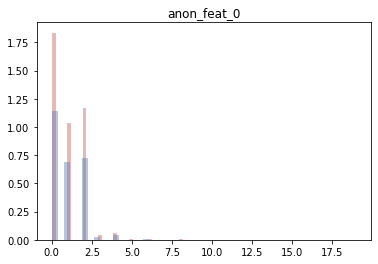

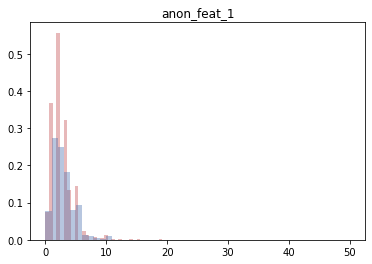

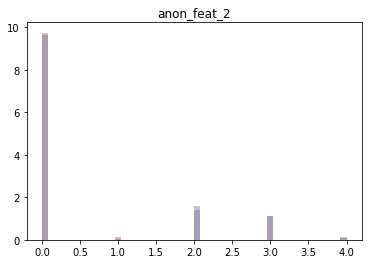

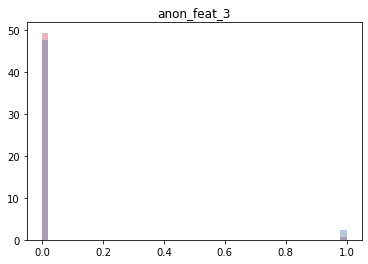

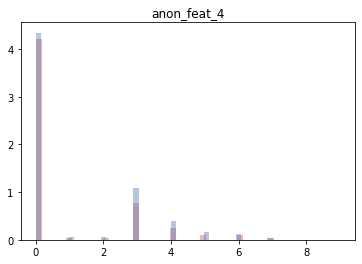

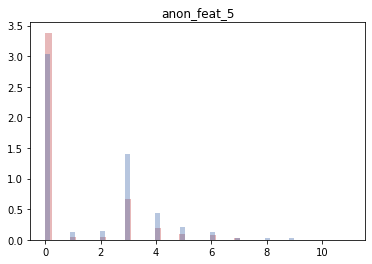

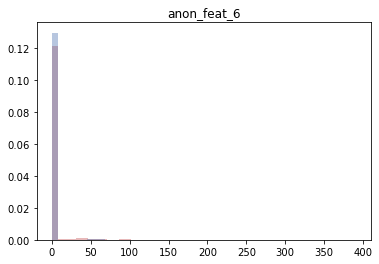

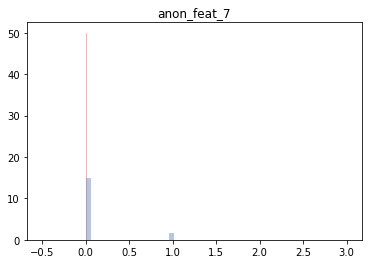

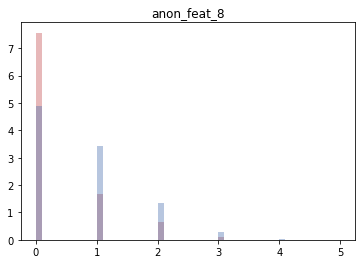

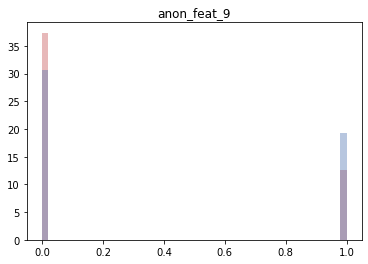

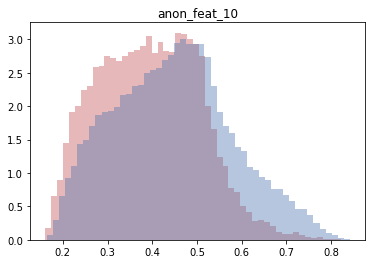

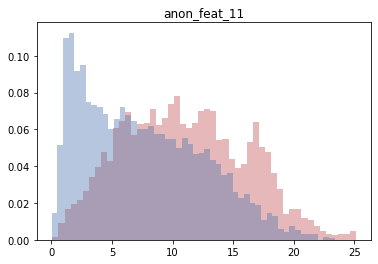

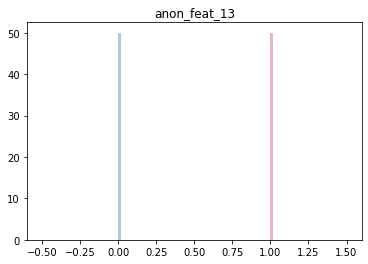

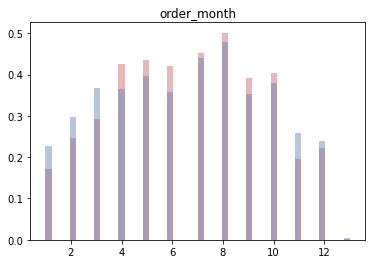

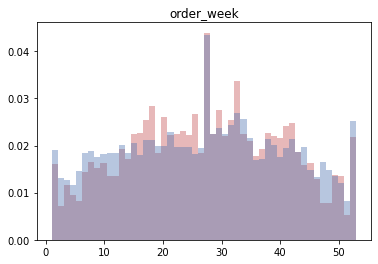

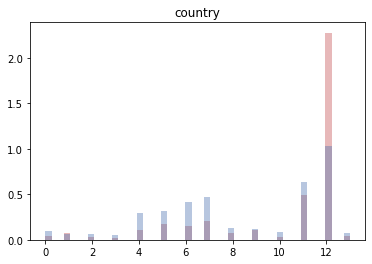

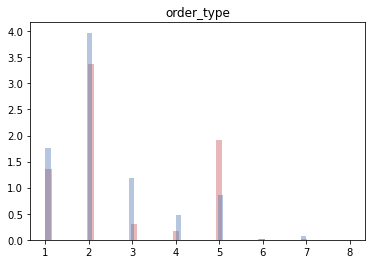

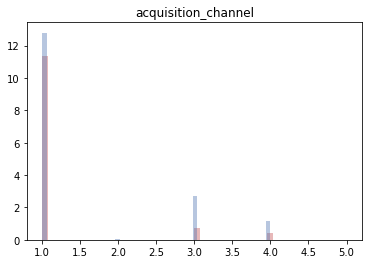

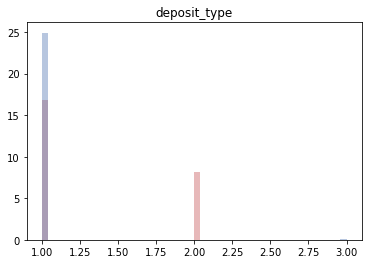

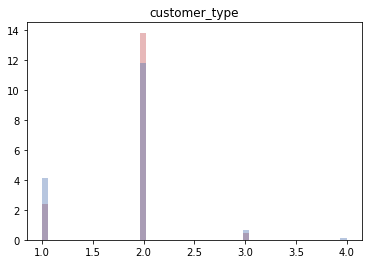

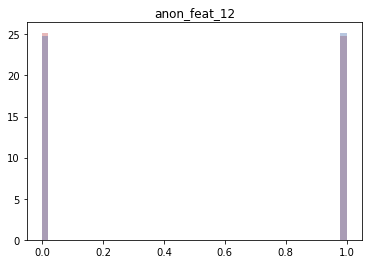

In [199]:
for col in X_num.columns:
    not_na = ~X_num[col].isna()
    pos = X_num[col][y_train['cancelation'].astype(bool)][not_na]
    neg = X_num[col][~y_train['cancelation'].astype(bool)][not_na]
    plt.hist(pos.replace(np.nan, -2), color ='r', alpha=0.4, bins=50, label='Positive', density = True)
    plt.hist(neg.replace(np.nan, -2), color='b', alpha=0.4, bins=50, label ='Negative', density = True)
    #plt.ylim(0, 0.00005)
    #plt.xlim(2400, 30000)
    plt.title(col)
    plt.show()

# 2 - Preprocessing

## 2.1 Handling outlayers

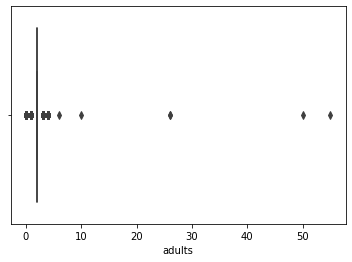

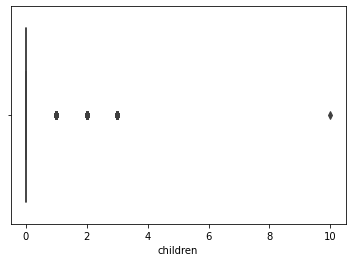

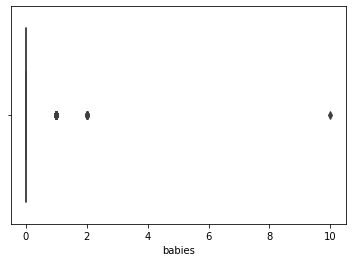

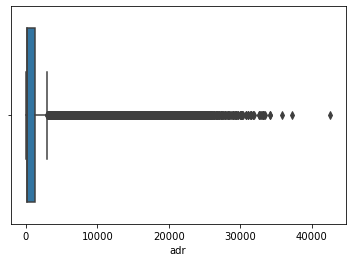

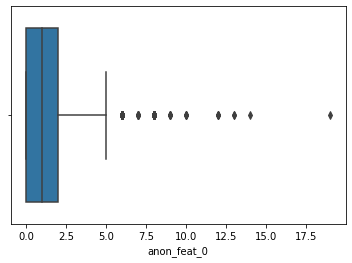

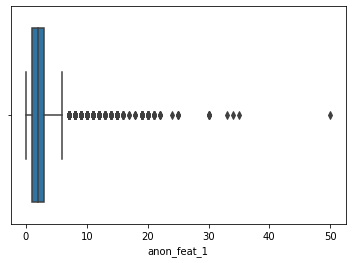

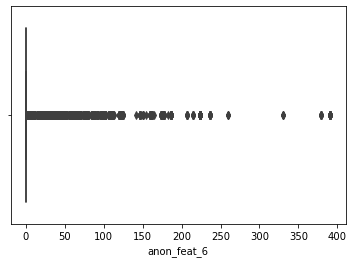

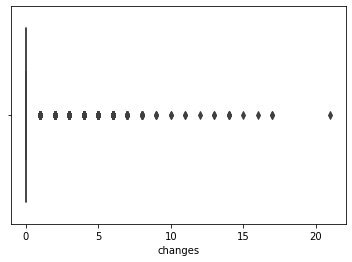

In [200]:
# outliers visulaization - with boxplot
for col in ['adults','children','babies','adr','anon_feat_0','anon_feat_1','anon_feat_6', 'changes']:
    ax = sns.boxplot(x=X_num[col])
    plt.show()
    

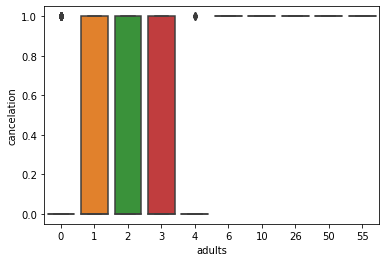

<Figure size 504x360 with 0 Axes>

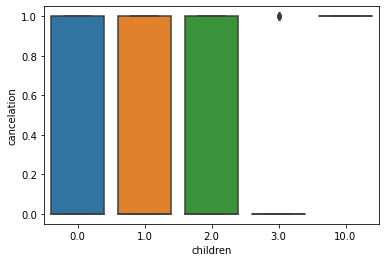

<Figure size 504x360 with 0 Axes>

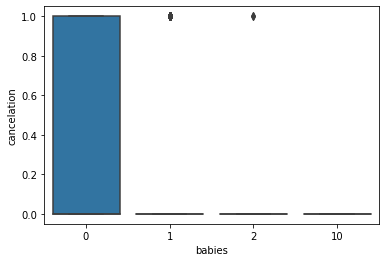

<Figure size 504x360 with 0 Axes>

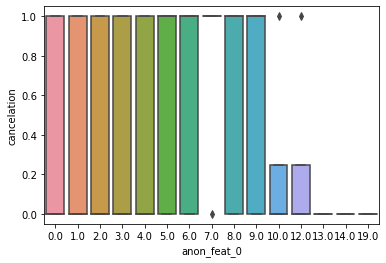

<Figure size 504x360 with 0 Axes>

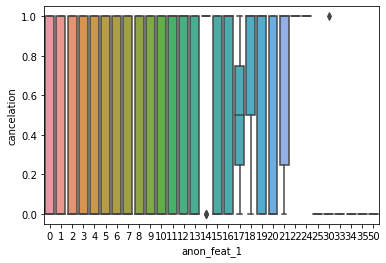

<Figure size 504x360 with 0 Axes>

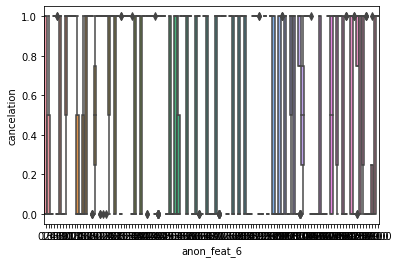

<Figure size 504x360 with 0 Axes>

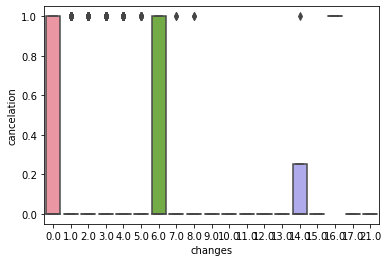

<Figure size 504x360 with 0 Axes>

In [201]:
#add after understanding the  outliers, we want to get a feeling where should we cut the outliers
#and we can also use the labels in order to do so:


for col in ['adults','children','babies','anon_feat_0','anon_feat_1','anon_feat_6', 'changes']:
    ax = sns.boxplot(x=col, y='cancelation', data = new_df)
    plt.figure(figsize=(7,5))
    plt.show()
 

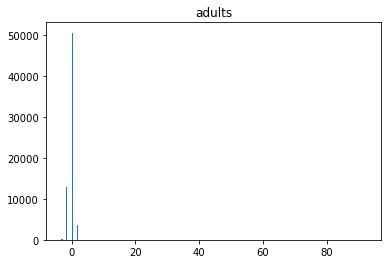

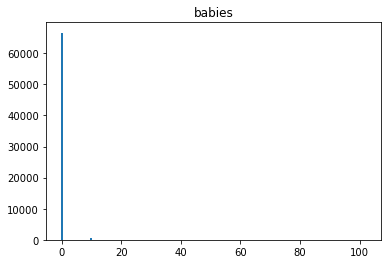

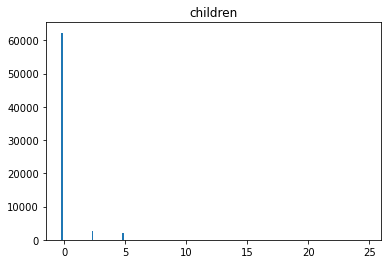

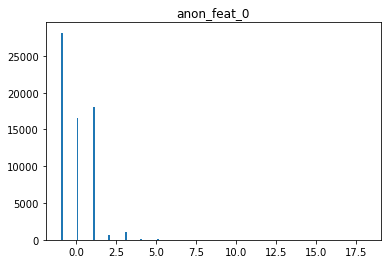

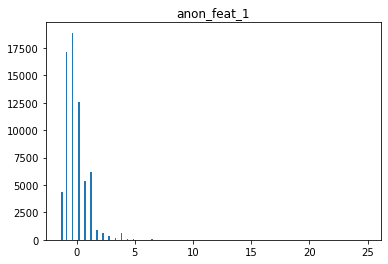

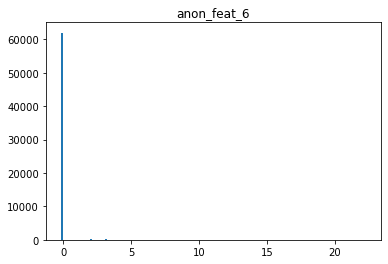

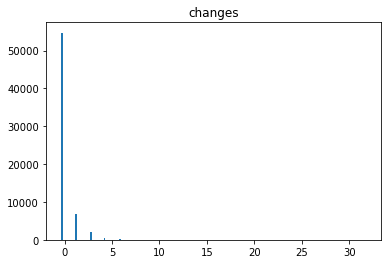

,adults,babies,children,anon_feat_0,anon_feat_1,anon_feat_6,changes
3.0,0.000536,0.007743,0.031509,0.018271,0.014295,0.015069,0.013029
4.0,0.000089,0.007743,0.031509,0.002814,0.003470,0.009560,0.013029
4.5,0.000089,0.007743,0.031509,0.002144,0.003008,0.008532,0.005301
5.0,0.000089,0.007743,0.000640,0.002144,0.002546,0.007862,0.005301
6.0,0.000089,0.007743,0.000640,0.000834,0.002308,0.005495,0.002219
7.0,0.000089,0.007743,0.000640,0.000730,0.001281,0.004080,0.002219
10.0,0.000074,0.007743,0.000015,0.000119,0.000268,0.002323,0.000611


In [202]:
# 1. we want to handle ['adults','children','babies','adr'- we'll remove,'anon_feat_0-1,6', 'changes']
# 2. maybe we won't touch these featuresת because we can get the intuition that these outliers  will be important?
# 

#first, we'll look at the z-scores table and different thresholds for cutting the outliers
out = ['adults','babies','children', 'anon_feat_0','anon_feat_1','anon_feat_6','changes']
thresh = [3, 4, 4.5, 5,6,7,10]
z_scores_feat = pd.DataFrame(index=thresh, columns=out)
z_scores_feat = z_scores_feat.fillna(0)
for t in thresh:
    for col in out:
        z_scores = ((X_num[col]-X_num[col].mean())/X_num[col].std(ddof=0))
        if (t==3):
            z_scores.hist(bins=200, grid=False)
            #plt.xlim(-5, 12)
            #plt.ylim(0, 400)
            plt.title(col)
            plt.show()
        #creating a dataframe contains the percentage of data loss according to each z-score threshold and feature, on 
        #which we base our decision for the threshold cut of each feature
        z_scores_feat.loc[t, col] = (z_scores>=t).mean() 
        
#presenting the results
z_scores_feat

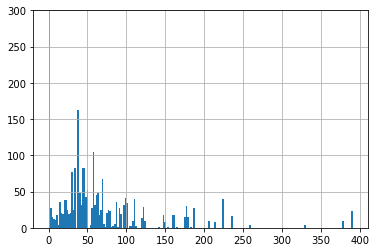

In [203]:
#annon_feat_6: we can remove the zeroes to a new binary feature 'is0_annon_feat_6', and then normalize the rest of the values 
X_num['anon_feat_6'].hist(bins=200)
plt.ylim(0, 300)
plt.show()


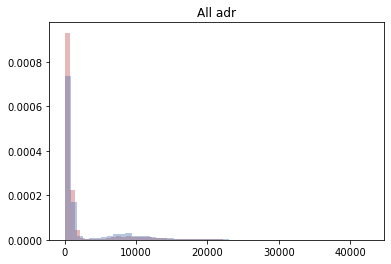

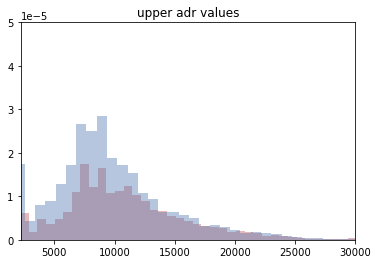

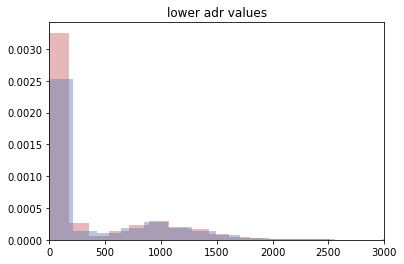

In [204]:
#adr: we can divide this feature into 2 features according to a threshold: 

#we can see that this feature can be divided to 2 distributions by a threshold value:
not_na = ~X_num['adr'].isna()
pos = X_num['adr'][y_train['cancelation'].astype(bool)][not_na]
neg = X_num['adr'][~y_train['cancelation'].astype(bool)][not_na]
plt.hist(pos.replace(np.nan, -2), color ='r', alpha=0.4, bins=50, label='Positive', density = True)
plt.hist(neg.replace(np.nan, -2), color='b', alpha=0.4, bins=50, label ='Negative', density = True)
plt.title('All adr')
plt.show()

# the upper values tend to have less cancelation
not_na = ~X_num['adr'].isna()
pos = X_num['adr'][y_train['cancelation'].astype(bool)][not_na]
neg = X_num['adr'][~y_train['cancelation'].astype(bool)][not_na]
plt.hist(pos.replace(np.nan, -2), color ='r', alpha=0.4, bins=50, label='Positive', density = True)
plt.hist(neg.replace(np.nan, -2), color='b', alpha=0.4, bins=50, label ='Negative', density = True)
plt.ylim(0, 0.00005)
plt.xlim(2200, 30000)
plt.title("upper adr values")
plt.show()

#lower values have more cancelation
not_na = ~X_num['adr'].isna()
pos = X_num['adr'][y_train['cancelation'].astype(bool)][not_na]
neg = X_num['adr'][~y_train['cancelation'].astype(bool)][not_na]
plt.hist(pos.replace(np.nan, -2), color ='r', alpha=0.4, bins=200, label='Positive', density = True)
plt.hist(neg.replace(np.nan, -2), color='b', alpha=0.4, bins=200, label ='Negative', density = True)
#plt.ylim(0, 0.00005)
plt.xlim(0, 3000)
plt.title("lower adr values")
plt.show()

In [205]:
#we'll use 2 methods for handeling the outlieres- z-score threshold or value method. After looking the the z-score distribution
#and correlations with labele we decided to use to remove:adults >3z, babies >1v, children >3v, anon_0>4v, anon_1>5z, changes>4v
#annon6 - create new binary feature 'is0_annon_feat_6'. then well normalize all other values in a way that will ignore the zeroes

#after choosing the propper threshold for each feature, we're using it to cut the outliers:
z_out = ['adults','anon_feat_1']
z_thresh = [3, 5]
v_out = ['babies','children','anon_feat_0','changes']
v_thresh = [1,3,4,4]

print("x shpae before:", X_num.shape)
print("y shpae before:", y_train.shape)

def remove_outliers_by_zscore_threshold(X,y, feat_vec, thresh_vec):
    for col,z in zip(feat_vec,thresh_vec):
        z_scores = ((X[col]-X[col].mean())/X[col].std(ddof=0))
        X, y = X[z_scores<z], y[z_scores<z]
    return X, y

def remove_outliers_by_value_threshold(X,y, feat_vec, thresh_vec):
    for col,v in zip(feat_vec,thresh_vec):
        X, y = X[(X[col]<=v)|(X[col].isna())], y[(X[col]<=v)|(X[col].isna())]
    return X, y
        
X_num, y_train = remove_outliers_by_zscore_threshold(X_num,y_train, z_out, z_thresh)
X_num, y_train = remove_outliers_by_value_threshold(X_num,y_train, v_out, v_thresh)
X_num.describe()

x shpae before: (67156, 34)
y shpae before: (67156, 2)


,id,time_until_order,order_year,order_day_of_month,adults,children,babies,prev_canceled,prev_not_canceled,changes,...,anon_feat_11,anon_feat_13,order_month,order_week,country,order_type,acquisition_channel,deposit_type,customer_type,anon_feat_12
count,66753.000000,57352.000000,66753.000000,66753.000000,66753.000000,66749.000000,66753.000000,66753.000000,66753.000000,64170.000000,...,63086.000000,4283.000000,66753.000000,66753.000000,66753.000000,66753.000000,66753.000000,60008.000000,59413.000000,66753.000000
mean,59754.709466,103.451894,2016.157881,15.836022,1.854613,0.104496,0.007565,0.086648,0.140563,0.207387,...,8.831737,0.359795,6.560619,27.162839,9.029856,2.522059,1.414393,1.124967,1.834750,0.500697
std,34465.559411,106.915447,0.707330,8.776449,0.484726,0.398846,0.086649,0.841858,1.507860,0.560844,...,5.239799,0.479996,3.086396,13.576503,3.450885,1.370289,0.906352,0.335040,0.483964,0.500003
min,0.000000,0.000000,2015.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.038632,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,29941.000000,18.000000,2016.000000,8.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,4.435109,0.000000,4.000000,16.000000,6.000000,2.000000,1.000000,1.000000,2.000000,0.000000
50%,59743.000000,68.000000,2016.000000,16.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,8.402076,0.000000,7.000000,28.000000,11.000000,2.000000,1.000000,1.000000,2.000000,1.000000
75%,89557.000000,159.000000,2017.000000,23.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,12.692419,1.000000,9.000000,38.000000,12.000000,3.000000,1.000000,1.000000,2.000000,1.000000
max,119388.000000,629.000000,2017.000000,31.000000,3.000000,3.000000,1.000000,26.000000,72.000000,4.000000,...,25.139670,1.000000,13.000000,53.000000,13.000000,8.000000,5.000000,3.000000,4.000000,1.000000


## 2.2 Creating new features

In [206]:
def create_new_features(X):
    #'cancelation_percentage'
    X['cancelation_percentage'] = X['prev_canceled']/(X['prev_canceled']+X['prev_not_canceled'])
    X['cancelation_percentage'].fillna(0, inplace = True)

    #'is0_annon_feat_6'
    X['is0_anon_feat_6'] = np.where(X['anon_feat_6']==0, 1, (np.where(X['anon_feat_6'].isna(), np.nan, 0)))

create_new_features(X_num)
X_num.to_csv("X_train_before_preprocessing.csv")

## 2.3 Normalization

## 2.4 Filling missing values

In [207]:
#Drop non interseting features
def drop_features(X):
    X.drop(['company', 'anon_feat_13','adr','anon_feat_5','prev_canceled','prev_not_canceled','order_year'],axis = 1,inplace = True)
    return X
# remove later: ['order_day_of_month', 'anon_feat_12']
# and also maybe: ['agent']

In [208]:
#fill by median
med_feat = ['agent','changes','anon_feat_6','is0_anon_feat_6','anon_feat_0','children']

def fill_median(X): 
    for c in med_feat:
        imp = SimpleImputer(strategy='median')
        imp.fit(X[[c]])
        X[c] = imp.transform(X[[c]])
    return X

In [209]:
#fill by mean
mea_feat = ['time_until_order','anon_feat_7','anon_feat_10','anon_feat_11']
def fill_mean(X):
    for c in mea_feat:
        imp = SimpleImputer(strategy='mean')
        imp.fit(X[[c]])
        X[c] = imp.transform(X[[c]])
    return X


In [210]:
#fill by most_frequent the missing categorial data
#The function calculates the frequency of the data and fits by frequency the missing values
by_freq = ['deposit_type','customer_type','anon_feat_9']
def fill_freq(X):
    for c in by_freq:
        missing = X[c].isnull()
        s = X[c].value_counts(normalize=True)
        #print('\n\n',c, 'distribution before replacing NA values:\n',s)
        X.loc[missing,c] = np.random.choice(s.index, size=len(X[missing]),p=s.values)
        #print ('After replacing:\n',X[c].value_counts(normalize=True))
    return X


In [211]:
#Fill missing values in train - 
def preprocessing (X):
    X = drop_features(X)
    X = fill_median(X)
    X = fill_mean(X)
    X = fill_freq(X)
    return X

In [212]:
#Preprocessing Train
X_train_copy = X_num.copy()
preprocessing(X_train_copy)
X_train_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66753 entries, 72578 to 15795
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      66753 non-null  int64  
 1   time_until_order        66753 non-null  float64
 2   order_day_of_month      66753 non-null  int64  
 3   adults                  66753 non-null  int64  
 4   children                66753 non-null  float64
 5   babies                  66753 non-null  int64  
 6   changes                 66753 non-null  float64
 7   agent                   66753 non-null  float64
 8   anon_feat_0             66753 non-null  float64
 9   anon_feat_1             66753 non-null  int64  
 10  anon_feat_2             66753 non-null  int64  
 11  anon_feat_3             66753 non-null  int64  
 12  anon_feat_4             66753 non-null  int64  
 13  anon_feat_6             66753 non-null  float64
 14  anon_feat_7             66753 non-

In [213]:
X_train_copy.to_csv("X_train_copy.csv")

## 2.5 Using One-Hot encoding (get.dummies) for selected categorial features

In [232]:
#using it on ['order_type'?,'acquisition_channel','deposit_type','customer_type','anon_feat_4','country'?]
dummies_col = ['order_type','acquisition_channel','deposit_type','customer_type','anon_feat_4']
X_train_copy_onehot = X_train_copy.copy()
X_train_copy_onehot = pd.get_dummies(X_train_copy_onehot, columns=dummies_col)

X_train_copy_onehot.to_csv("X_train_copy_onehot.csv")
X_train_copy_onehot.head()

,id,time_until_order,order_day_of_month,adults,children,babies,changes,agent,anon_feat_0,anon_feat_1,...,anon_feat_4_0,anon_feat_4_1,anon_feat_4_2,anon_feat_4_3,anon_feat_4_4,anon_feat_4_5,anon_feat_4_6,anon_feat_4_7,anon_feat_4_8,anon_feat_4_9
72578,32696,5.000000,30,2,2.0,0,0.0,250.0,1.0,2,...,0,0,0,0,0,0,1,0,0,0
66308,27250,127.000000,18,2,0.0,0,4.0,250.0,2.0,5,...,0,0,0,0,1,0,0,0,0,0
25709,84393,22.000000,22,2,0.0,0,0.0,9.0,1.0,2,...,0,0,0,1,0,0,0,0,0,0
40632,109652,103.451894,9,2,0.0,0,0.0,9.0,2.0,4,...,1,0,0,0,0,0,0,0,0,0
38959,116988,103.451894,25,3,0.0,0,0.0,9.0,0.0,3,...,0,0,0,1,0,0,0,0,0,0


# Test (Val) set pre-processing


Threshold: [0.9, 0.95, 0.99]
Number of countries included in this threshold:
 [14 22 53]

We chose to use 14 countries in order to describe 90% of the data

Country distribution after taking the 10% tail into a new 'other' country:


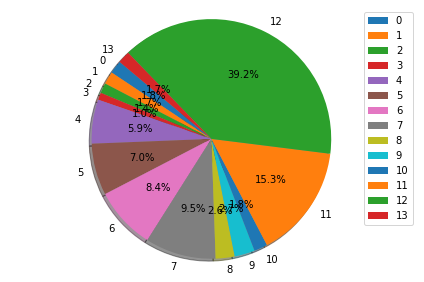

In [215]:
# Split numerical and categorial data of the test set
X_num_val, X_categ_val = num_cat_split(X_val)
#create copy for handeling categroial data
c1 = X_categ_val.copy()
#handeling categroial data
c1 = replace_cat(c1, categories, categ_dicts)
#join categorial transformed data
X_num_val = X_num_val.join(c1)
#add new features
create_new_features(X_num_val)

In [216]:
#Preprocessing Val -
X_num_val_copy = X_num_val.copy()
preprocessing(X_num_val_copy)
X_num_val_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22386 entries, 23476 to 19170
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      22386 non-null  int64  
 1   time_until_order        22386 non-null  float64
 2   order_day_of_month      22386 non-null  int64  
 3   adults                  22386 non-null  int64  
 4   children                22386 non-null  float64
 5   babies                  22386 non-null  int64  
 6   changes                 22386 non-null  float64
 7   agent                   22386 non-null  float64
 8   anon_feat_0             22386 non-null  float64
 9   anon_feat_1             22386 non-null  int64  
 10  anon_feat_2             22386 non-null  int64  
 11  anon_feat_3             22386 non-null  int64  
 12  anon_feat_4             22386 non-null  int64  
 13  anon_feat_6             22386 non-null  float64
 14  anon_feat_7             22386 non-

# 3 - Modeling

In [217]:
#run PCA
pca = PCA()
data_for_pca = (X_train_copy - X_train_copy.mean())/(X_train_copy.std())
data = pca.fit_transform(data_for_pca)

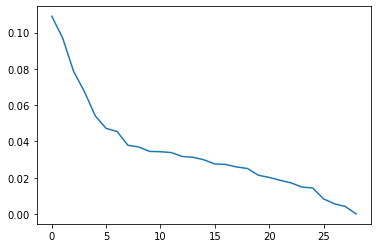

In [218]:
plt.plot(pca.explained_variance_ratio_)

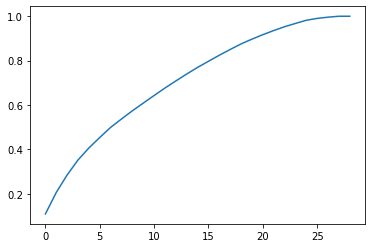

In [219]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))

In [220]:
for variance in [0.95, 0.99, 0.9999999999999999]:
    pca = PCA(variance, whiten=True)
    data = pca.fit_transform(data_for_pca)
    print("For explained variance:", variance, "number of dimensions:", data.shape[1])

For explained variance: 0.95 number of dimensions: 23
For explained variance: 0.99 number of dimensions: 26
For explained variance: 0.9999999999999999 number of dimensions: 29


In [221]:
pca = PCA(n_components = 0.95)
X_train_copy_pca = pca.fit_transform(data_for_pca)
#We have decided not to use PCA since it wouldn't reduce much the dimensionality and we won't gain much by using it

In [222]:
#run classifieres 
knn = KNeighborsClassifier(n_neighbors=3)
lr = LogisticRegression(max_iter=100, penalty='l2')
ann = MLPClassifier(activation = 'relu',hidden_layer_sizes=100)
rf = RandomForestClassifier(criterion = 'entropy')

clfs = [lr,ann,rf]

In [223]:
#implementing Kfold -
k = 5
kf = KFold(n_splits=k, random_state=None) 

LogisticRegression()


C:\Users\Nili\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Nili\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

Avg accuracy: 0.7192185163646931
test


C:\Users\Nili\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


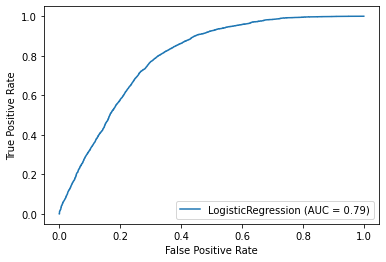

train


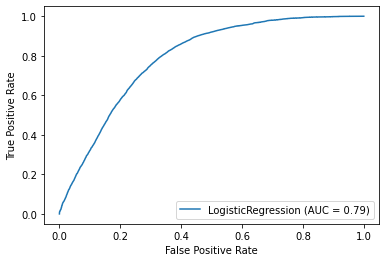

test


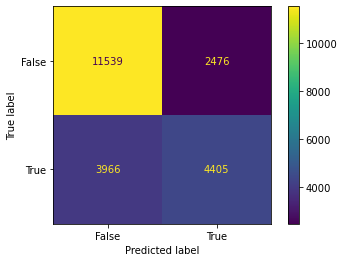

train


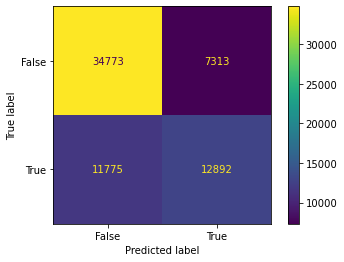

MLPClassifier(hidden_layer_sizes=100)
Avg accuracy: 0.7230704597307445
test


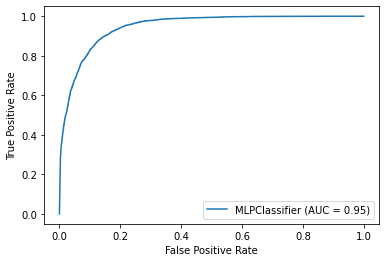

train


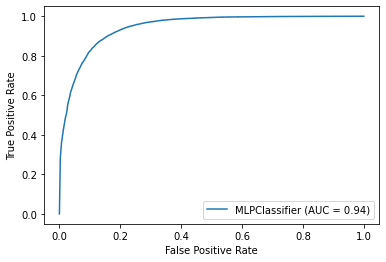

test


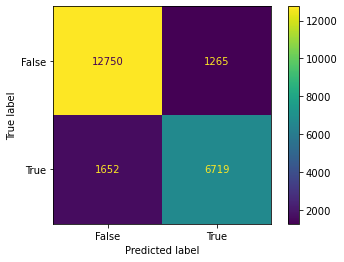

train


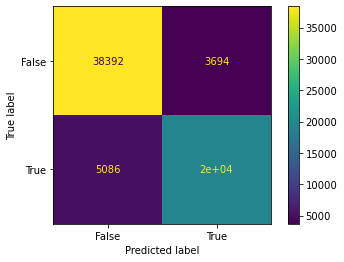

RandomForestClassifier(criterion='entropy')
Avg accuracy: 0.9783979934452021
test


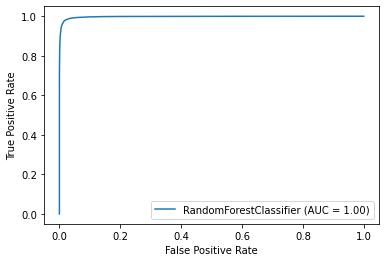

train


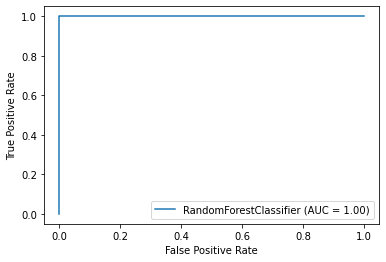

test


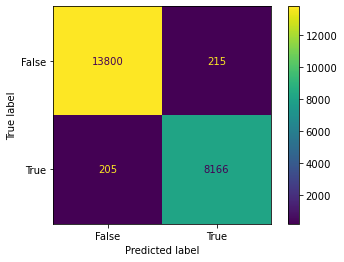

train


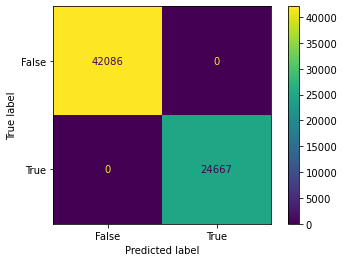

In [224]:
for clf in clfs:
    print(clf)
    clf.fit(X_train_copy, y_train['cancelation'])
    cv_scores = cross_val_score(clf, X_train_copy, y_train['cancelation'], cv=kf)
    print("Avg accuracy: {}".format(cv_scores.mean()))
    print('test')
    plot_roc_curve(clf,X_num_val_copy,y_val['cancelation'])
    plt.show()
    print('train')
    plot_roc_curve(clf,X_train_copy,y_train['cancelation'])
    plt.show()
    print('test')
    plot_confusion_matrix(clf,X_num_val_copy,y_val['cancelation'])
    plt.show()
    print('train')
    plot_confusion_matrix(clf,X_train_copy,y_train['cancelation'])
    plt.show()

In [225]:
misclassifiedIndexes = np.where(y_train['cancelation']!=clf.predict(X_train_copy))[0]
X_train_copy.loc[misclassifiedIndexes,:]

,id,time_until_order,order_day_of_month,adults,children,babies,changes,agent,anon_feat_0,anon_feat_1,...,order_month,order_week,country,order_type,acquisition_channel,deposit_type,customer_type,anon_feat_12,cancelation_percentage,is0_anon_feat_6


In [226]:
knn.fit(X_train_copy,y_train['cancelation'])
#train model with cv of 5 
#print each cv score (accuracy) and average them
print(cv_scores)
print('cv_scores mean:{}'.format(np.mean(cv_scores)))

[0.97880309 0.97588196 0.97925249 0.97827715 0.97977528]
cv_scores mean:0.9783979934452021


In [227]:
#Choose best knn

#create a dictionary of all values we want to test for n_neighbors
param_grid = {'n_neighbors':[1,3,5]}
#use gridsearch to test all values for n_neighbors
knn_gscv = GridSearchCV(knn, param_grid, cv=5)
#fit model to data
knn_gscv.fit(X_train_copy, y_train['cancelation'])

GridSearchCV(cv=5, estimator=KNeighborsClassifier(n_neighbors=3),
             param_grid={'n_neighbors': [1, 3, 5]})

In [228]:
print(knn_gscv.best_params_, '\n', knn_gscv.best_score_)
#we will choose knn with 3 neighbors

{'n_neighbors': 3} 
 0.9534403432306127


Threshold: [0.9, 0.95, 0.99]
Number of countries included in this threshold:
 [14 22 56]

We chose to use 14 countries in order to describe 90% of the data

Country distribution after taking the 10% tail into a new 'other' country:


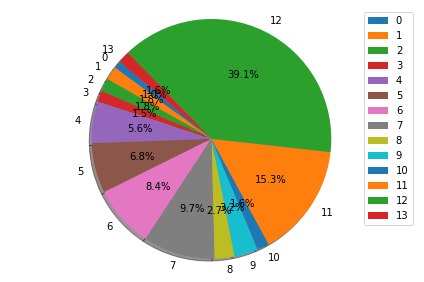

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29848 entries, 0 to 29847
Data columns (total 36 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      29848 non-null  int64  
 1   time_until_order        25595 non-null  float64
 2   order_year              29848 non-null  int64  
 3   order_day_of_month      29848 non-null  int64  
 4   adults                  29848 non-null  int64  
 5   children                29848 non-null  float64
 6   babies                  29848 non-null  int64  
 7   prev_canceled           29848 non-null  int64  
 8   prev_not_canceled       29848 non-null  int64  
 9   changes                 28744 non-null  float64
 10  agent                   25704 non-null  float64
 11  company                 1735 non-null   float64
 12  adr                     28821 non-null  float64
 13  anon_feat_0             28757 non-null  float64
 14  anon_feat_1             29848 non-null

In [229]:
#Split numerical and categorial data of the test set
X_num_test, X_categ_test = num_cat_split(T)
#create copy for handeling categroial data
c2 = X_categ_test.copy()
#handeling categroial data
c2 = replace_cat(c2, categories, categ_dicts)
#join categorial transformed data
X_num_test = X_num_test.join(c2)
#add cancelation_percentage
create_new_features(X_num_test)
X_num_test.info()



In [230]:
#Preprocessing test -
X_num_test_copy = X_num_test.copy()
preprocessing(X_num_test_copy)
X_num_test_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29848 entries, 0 to 29847
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      29848 non-null  int64  
 1   time_until_order        29848 non-null  float64
 2   order_day_of_month      29848 non-null  int64  
 3   adults                  29848 non-null  int64  
 4   children                29848 non-null  float64
 5   babies                  29848 non-null  int64  
 6   changes                 29848 non-null  float64
 7   agent                   29848 non-null  float64
 8   anon_feat_0             29848 non-null  float64
 9   anon_feat_1             29848 non-null  int64  
 10  anon_feat_2             29848 non-null  int64  
 11  anon_feat_3             29848 non-null  int64  
 12  anon_feat_4             29848 non-null  int64  
 13  anon_feat_6             29848 non-null  float64
 14  anon_feat_7             29848 non-null

In [231]:
#Predict_proba_with_random_forest
resultingDF = pd.DataFrame()
prediction = rf.predict_proba(X_num_test_copy)[:,1]
resultingDF['id'] =X_num_test_copy['id']
resultingDF['prediction'] =prediction.tolist()
resultingDF.to_csv("results.csv")